In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
import eli5
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
import models
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
from tqdm import tqdm
from style import *
from sklearn import decomposition
import matplotlib.gridspec as grd
import itertools
from sklearn import mixture
from matplotlib_venn import venn3, venn2
import viz
outcome_def = 'y_consec_thresh'

In [3]:
df = data_tracks.get_data(use_processed=False, use_processed_dicts=True, 
                           outcome_def=outcome_def)
viz.print_metadata()

loading + preprocessing data...
	loading tracks...
	preprocessing data...
	removing hotspots....
	adding features...
valid:		1966.0 aux+ / 7594 (0.259)
----------------------------------------
no_hotspots:	1741.0 aux+ / 7357 (0.237)
----------------------------------------
lifetime<=26:	4720 aux+ / 5127 (0.921)
lifetime>=145:	  62 aux- /   67 (0.925)
remaining:	1272 aux+ / 2163 (0.588)


# visualize outcomes
- take mean, take sigma, define events with a threshold

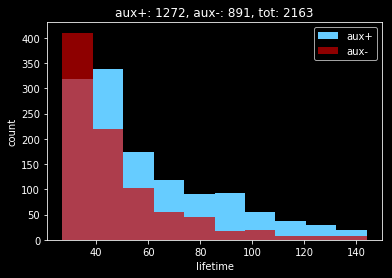

In [6]:
outcome = df[outcome_def]
aux_pos = df['lifetime'][outcome==1] 
aux_neg = df['lifetime'][outcome==0] 
plt.hist(aux_pos, label='aux+', alpha=1, color=cb)
plt.hist(aux_neg, label='aux-', alpha=0.7, color=cr)
plt.xlabel('lifetime')
plt.ylabel('count')
plt.title(f'aux+: {aux_pos.shape[0]}, aux-: {aux_neg.shape[0]}, tot: {df.shape[0]}')
plt.legend()
plt.show()

In [6]:
def sort_outcome(df, outcome_def):
    outcome_score = df['Y_max'].values
    idxs_sort = np.argsort(outcome_score)
    return df[outcome_def].values[idxs_sort], df['Y'].values[idxs_sort]

outcome_sort, Y_sort = sort_outcome(df, outcome_def)

### Find rule-based model to define aux+

In [111]:
#sig_diff_1 = (df['y_sig_min_diff'] <= 1)
y_orgn = np.logical_or(df['y_consec_sig'], df['y_conservative_thresh'])
len(np.where(y_orgn != df['y_consec_thresh'])[0])
#df['pid'].values[np.where(y_orgn < df['y_consec_thresh'])]

115

In [157]:
def cummax(arr):
    res = [arr[0]]
    for i in range(1, len(arr)):
        res.append(max(arr[i], res[i-1]))
    return res
    
def max_fall(arr):
    cm = cummax(arr)
    return np.max(np.array(cm) - np.array(arr))
    
def max_diff(arr):
    return np.max(-np.diff(arr)) 

def max_absolute_fall(arr):
    cm_rev = cummax(arr[::-1])[::-1]
    return max(arr[i] - cm_rev[i+1] for i in range(len(arr)-1))



In [72]:
# peak time
df['Y_peak_time_frac'] = df['Y_peak_idx'].values / df['lifetime'].values
df['peak_time_frac_diff'] = df['Y_peak_time_frac']  - df['X_peak_time_frac'] 

In [194]:
# local
X_max_around_Y_peak = []
X_max_before_Y_peak = []
X_max_after_Y_peak = []
X_max_fall_around_Y_peak = []
X_max_diff_around_Y_peak = []
X_max_abs_fall_around_Y_peak = []
for i in range(len(df)):
    pt = df['Y_peak_idx'].values[i]
    lt = df['lifetime'].values[i]
    left_bf = np.int(0.3 * lt)
    right_bf = np.int(0.1 * lt)
    arr_before = df['X'].iloc[i][: max(1, pt - left_bf)]
    arr_around = df['X'].iloc[i][max(0, pt - left_bf): min(pt + right_bf, lt)]
    arr_after = df['X'].iloc[i][min(pt + right_bf, lt - 1): ]
    X_max_fall_around_Y_peak.append(max_fall(arr_around))
    X_max_diff_around_Y_peak.append(max_diff(arr_around))
    X_max_before_Y_peak.append(min(arr_before))
    X_max_around_Y_peak.append(max(arr_around))
    X_max_after_Y_peak.append(max(arr_after))
    #X_max_abs_fall_around_Y_peak.append(max_absolute_fall(arr))
    
df['X_max_fall_around_Y_peak'] = X_max_fall_around_Y_peak
#df['X_max_abs_fall_around_Y_peak'] = X_max_abs_fall_around_Y_peak
df['X_max_diff_around_Y_peak'] = X_max_diff_around_Y_peak
df['X_max_around_Y_peak'] = X_max_around_Y_peak
df['X_max_before_Y_peak'] = X_max_before_Y_peak
df['X_max_after_Y_peak'] = X_max_after_Y_peak
df['X_max_diff_around_before'] = df['X_max_around_Y_peak'] - df['X_max_before_Y_peak']
df['X_max_diff_around_after'] = df['X_max_around_Y_peak'] - df['X_max_after_Y_peak']
#df['X_local_glbal_max_diff'] = df['X_max_around_Y_peak'] - df['X_max']
#df['X_local_glbal_max_ratio'] = df['X_max_around_Y_peak']/df['X_max']

In [128]:
df['X_local_glbal_max_diff'] = df['X_max_around_Y_peak'] - df['X_max']
df['X_local_glbal_max_ratio'] = df['X_max_around_Y_peak']/df['X_max']

In [ ]:
print(df['Y_max'].values[np.where(df['y_consec_thresh'] > y_orgn)])
print(df['y_num_sig'].values[np.where(df['y_consec_thresh'] > y_orgn)])
print(arr)

In [238]:
#print(df['X_max_diff_around_after'].values[np.where(df['y_consec_thresh'] == 0)][:100] + 
#      df['X_max_diff_around_before'].values[np.where(df['y_consec_thresh'] == 0)][:100])
a1 = df['X_max_diff_around_before'].values[np.where(df['y_consec_thresh'] == 0)][:100]
#print(df['X_max_diff_around_after'].values[np.where(df['y_consec_thresh']  == 0)][:100])
a2 = df['X_max_diff_around_after'].values[np.where(df['y_consec_thresh']  == 0)][:100]
a3 = df['Y_max'].values[np.where(df['y_consec_thresh']  == 0)][:100]
a4 = df['y_num_sig'].values[np.where(df['y_consec_thresh']  == 0)][:100]
#a3 = df['Y_peak_time_frac'].values[np.where(df['y_consec_thresh']  == 0)][:100]

ol = np.where(a2 > 500)[0]
print(np.where(a1 + a2 > 200)[0])
print(a3[ol])
print(a4[ol])

print(ol)
arr = df['X_max_diff_around_after'].values[np.where(df['y_consec_thresh'] > y_orgn)]
arr2 = df['X_max_diff_around_before'].values[np.where(df['y_consec_thresh'] > y_orgn)]
fp = np.where(arr < 500)[0]
fp2 = np.where(arr + arr2 < 200)[0]
print(fp)
print(fp2)

[ 3  6  8 12 13 14 15 17 20 21 22 23 24 26 27 29 31 32 33 34 36 42 43 46
 48 51 53 56 57 61 62 64 66 68 69 71 72 73 75 76 77 79 80 81 82 84 85 86
 89 90 91 94 96 97 98]
[588.06462053 528.70126854 675.73913953 396.52029773 522.20510453
 362.58866736 514.23653869 609.03204532 510.81996395 503.46122607
 627.06931534 663.75945856 734.58917318 562.84335642 471.99773401
 953.19472207 512.21030692 671.28590805 449.44985756 519.46877462
 478.80757507 349.45698939 743.44366047 742.9982036  450.79879193
 492.42370001]
[1 0 1 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 5 0 0]
[ 3  6 12 13 14 15 20 21 22 23 27 29 33 48 51 61 66 68 71 73 76 79 81 82
 84 85]
[  5  13  15  31  35  38  40  45  50  60  65  78 100 104]
[  5  11  38  69  78 104]


In [142]:
df['X_local_glbal_max_diff'].values[np.where(df['y_consec_thresh'] == 0)][200:300]

array([ 0.00000000e+00, -3.80935472e+02,  0.00000000e+00,  0.00000000e+00,
       -7.89318975e+02,  0.00000000e+00, -6.52562275e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.28738243e+03,  0.00000000e+00,
       -1.83450638e+02, -9.70372070e+02,  0.00000000e+00,  0.00000000e+00,
       -6.15479137e+02, -1.77233416e+01, -3.54084351e+02, -1.46986014e+02,
       -5.99273299e+02, -5.20261099e+01, -9.60104960e+02,  0.00000000e+00,
        0.00000000e+00, -7.48490640e+02, -7.53660881e+02, -9.83695873e+02,
       -1.87357121e+02, -5.79216106e+02,  0.00000000e+00,  0.00000000e+00,
       -1.73820874e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -5.50558458e+02, -2.21172161e+02, -1.39111483e+02, -6.11224654e+01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.63078550e+02,
       -2.03259287e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.35056282e+02, -1.31328000e+02,  0.00000000e+00, -7.42816350e+02,
       -1.63493184e+02,  

In [136]:
df['X_max_fall_around_Y_peak'].values[np.where(df['y_consec_thresh'] < y_orgn)][:100]

array([ 809.27549098, 1593.03854586, 1427.89020308, 1417.71494337,
        535.00324899, 1328.75449587])

In [152]:
max(df['peak_time_frac_diff'].values[np.where(y_orgn > df['y_consec_thresh'])])

0.47222222222222227

In [239]:
Y_feat_names = ['y_consec_sig', 'y_conservative_thresh', 
                'Y_peak_time_frac', 
                'X_max_diff_around_after', 'X_max_diff_around_before']

In [243]:
cell_nums_feature_selection = np.array([1])
cell_nums_train = np.array([1, 2, 3, 4])
cell_nums_test = np.array([5])

outcome_def = 'y_consec_thresh'
X = df[Y_feat_names[:2]]
y = df[outcome_def].values
    
m = RandomForestClassifier(n_estimators=100)
    
kf = KFold(n_splits=len(cell_nums_train))
idxs_test = df.cell_num.isin(cell_nums_test)
X_test, Y_test = X[idxs_test], y[idxs_test]
idxs_train = df.cell_num.isin(cell_nums_train)
X_train, Y_train = X[idxs_train], y[idxs_train]
    #num_pts_by_fold_cv = []
    
    # build dictionary, key is leaf node, value is list of training samples in the node
    
m.fit(X_train, Y_train)
m.score(X_test, Y_test)

0.938337801608579

In [106]:
np.diff([1, 2, 3])

array([1, 1])

In [41]:
print(df['y_num_sig'].values[np.where(y_orgn != df['y_consec_thresh'])])
print(df['y_sig_min_diff'].values[np.where(y_orgn != df['y_consec_thresh'])])

[0 1 1 0 2 0 2 2 0 0 1 3 2 1 3 0 1 2 3 0 1 2 2 1 2 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 2 1 2 2 1 1 0 0 0 0 1 1 2 6 0 1 1 2 4 0 2 2 3 0 1 2 1 1 2 1
 1 3 0 0 3 1 1 2 4 1 2 0 1 1 2 2 0 1 1 2 0 1 2 1 2 1 2 1 1 3 0 2 1 1 2 1 0
 1 0 0 2]
[nan nan nan nan 18. nan  4.  3. nan nan nan 44.  2. nan  2. nan nan 27.
  2. nan nan  2.  1. nan  3. nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan  2. nan  2.  8. nan nan nan nan nan nan
 nan nan  2.  1. nan nan nan  3.  2. nan  4.  4.  3. nan nan 36. nan nan
 38. nan nan  2. nan nan  2. nan nan  2.  1. nan  2. nan nan nan  2.  1.
 nan nan nan  2. nan nan  7. nan  3. nan  3. nan nan  9. nan  1. nan nan
  2. nan nan nan nan nan  2.]


IndexError: index 8 is out of bounds for axis 0 with size 8

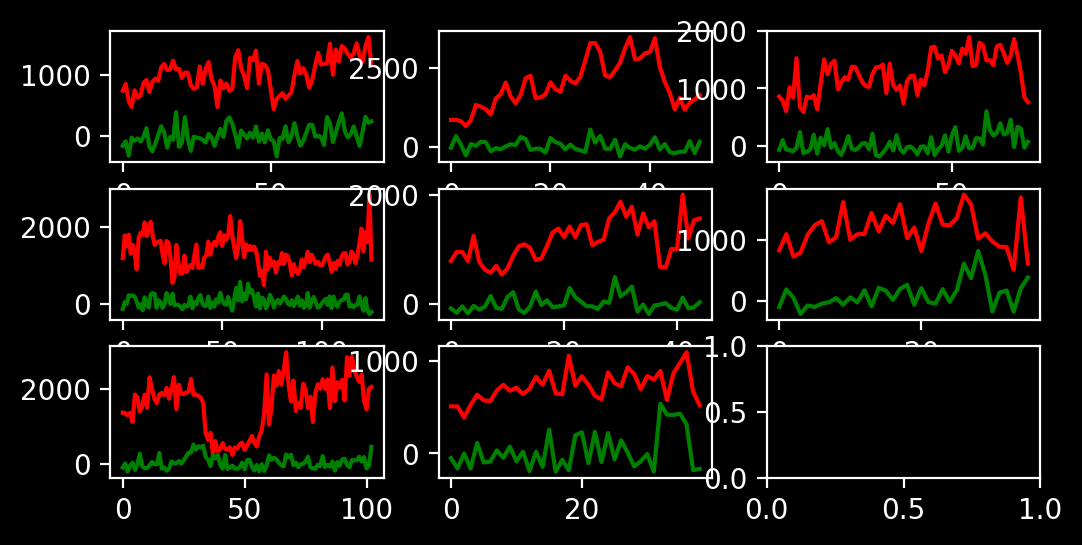

In [198]:
R, C = , 3
plt.figure(figsize=(6, 4), dpi=200)
lifetime_max = np.max(df.lifetime.values[:R*C])
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    row = df.iloc[i]
    n1 = np.where(y_orgn < df['y_consec_thresh'])[0][fp[i]]
    #n1 = np.where(df['y_consec_thresh'] == 1)[0][i]
    plt.plot(df.iloc[n1].X, color='red', label='clathrin')
    plt.plot(df.iloc[n1].Y, color='green', label='auxilin')
    #if not i == R * C - C:
    #plt.yticks([])
    #plt.xticks([])
plt.legend()
plt.tight_layout()
plt.show()

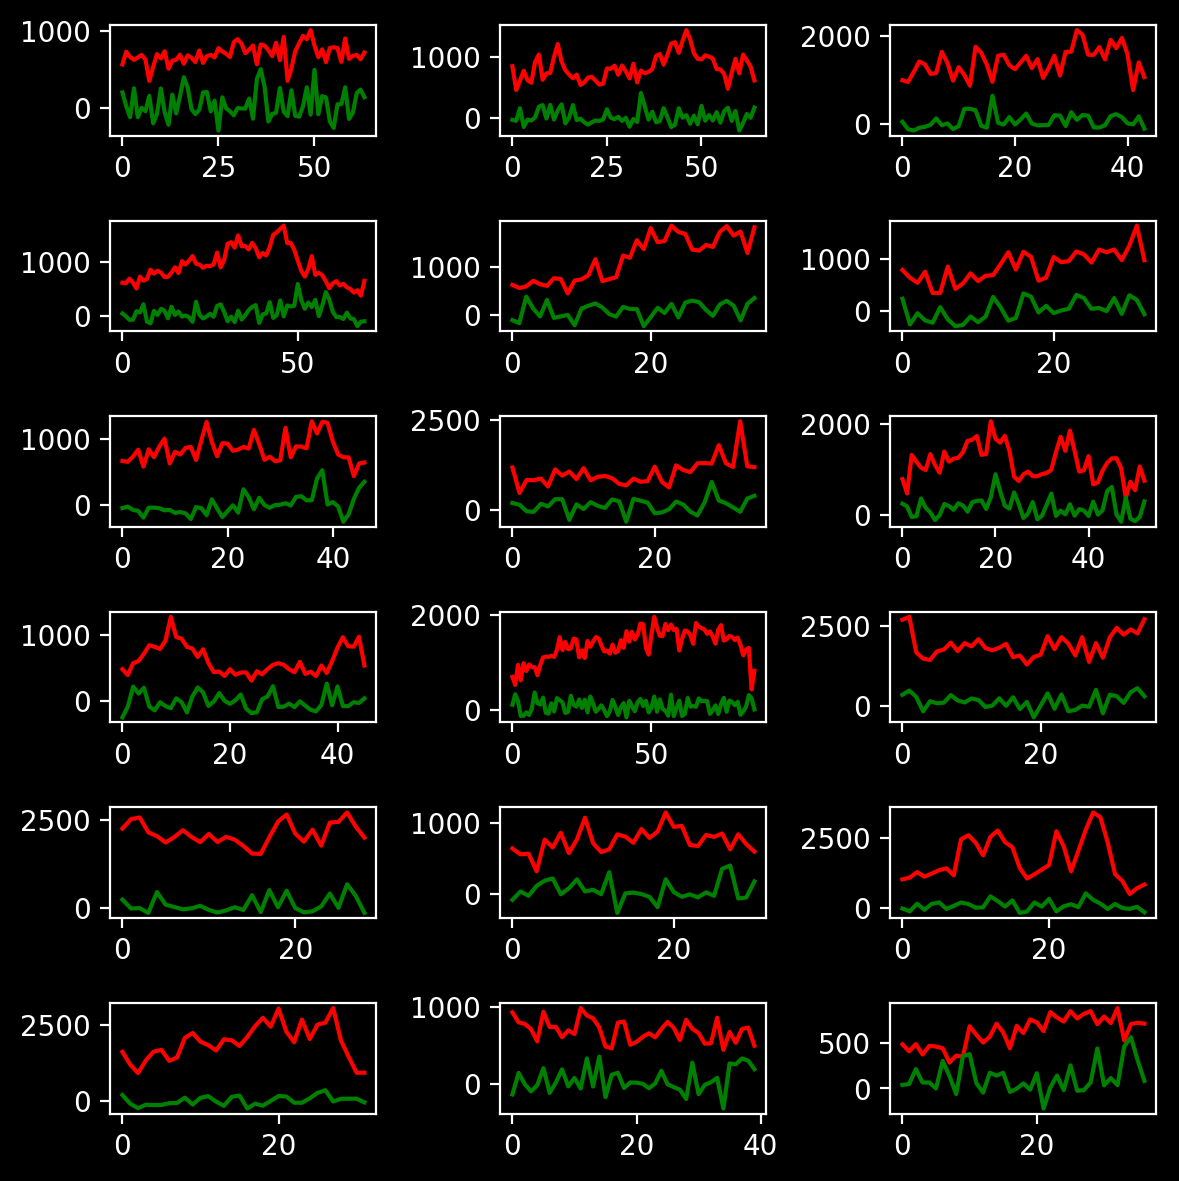

In [246]:
R, C = 6, 3
plt.figure(figsize=(6, 6), dpi=200)
lifetime_max = np.max(df.lifetime.values[:R*C])
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    row = df.iloc[i]
    n1 = np.where(df['y_consec_thresh'] == 0)[0][i]
    #n1 = np.where(df['y_consec_thresh'] == 1)[0][i]
    plt.plot(df.iloc[n1].X, color='red', label='clathrin')
    plt.plot(df.iloc[n1].Y, color='green', label='auxilin')
    #if not i == R * C - C:
    #plt.yticks([])
    #plt.xticks([])
#plt.legend()
plt.tight_layout()
plt.show()

In [178]:
df.iloc[1354].Y_peak_idx
pt = df['Y_peak_idx'].values[1354]
lt = df['lifetime'].values[1354]
bf = np.int(0.1 * lt)
arr = df['X'].iloc[1354][max(0, pt - 2*bf): min(pt + 2*bf, lt)]
print(arr)

[674.446232249678, 773.0831820069335, 923.4273765110731, 1053.130687935623, 1190.045832176428, 1002.3135254813454, 1215.7514278194196, 1444.942539945777, 1365.5581582647749, 1407.7571146283433, 1440.9522210242728, 1563.6250269778834, 1028.621777986839, 1444.1189482807029, 1213.5567637294894]


# viz curves

In [ ]:
viz.plot_curves(df[df.pid.isin(data_tracks.get_labels()['hotspots'])])

In [ ]:
R, C = 4, 5
# plt.figure(dpi=200)
plt.figure(figsize=(9, 8), dpi=200)
n = Y_sort.shape[0]
# idxs = list(range(10)) + list(range(n - 10, n)) # let's look at the top / bot
idxs = list(range(num_neg - 40, num_neg + 40)) # let's look at ones in the middle
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Y_sort[idx], color=cr if outcome_sort[idx] == 0 else cb)
#     plt.axis('off')
plt.tight_layout()

**compare as a func of aux_max**

In [ ]:
R, C = 20, 28
# plt.figure(dpi=200)
plt.figure(figsize=(28, 20))
n = Y_sort.shape[0] # 1434

idxs = np.array([np.arange(int(i), int(i) + C) for i in np.linspace(0, n - C, R)]).flatten() #list(range(10)) + list(range(n - 10, n))
Ys = Y_sort[idxs]
ymin = -200
ymax = 4000

for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Ys[i], color=cr if outcome_sort[idx] == 0 else cb, lw=1)
    plt.ylim((ymin - 1, ymax + 1))
    plt.xlim((0, 120))
    if not i == R * C - C:
        plt.yticks([])
        plt.xticks([])
    if i % C == 0:
        plt.ylabel(f'{np.max(Ys[i]):.0f}')
#     plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('def.pdf')

In [ ]:
aux_plus = df[outcome_def] == 1
plt.hist(df[aux_plus]['Y_max'], color=cb, label='aux+', bins=100)
plt.hist(df[~aux_plus]['Y_max'], color=cr, label='aux-', alpha=0.7, bins=100)
plt.xlabel('aux_max')
plt.ylabel('count')
plt.legend()
plt.show()

**look at hotspots**

In [16]:
dfh = data_tracks.get_data(use_processed=True, remove_hotspots=False,
                         processed_file='processed/df_with_hotspots.pkl', metadata_file='processed/metadata_with_hotspots.pkl',)

loading + preprocessing data...
	loading tracks...
	preprocessing data...
	adding features...
dict features not added!


In [ ]:
dh = dfh[df.hotspots==1]
R = int(np.sqrt(dh.shape[0]))
C = (dh.shape[0] // R) + 1
plt.figure(figsize=(C, R), dpi=200)

for i in range(R * C):
    if i < dh.shape[0]:
        ax = plt.subplot(R, C, i + 1)
        row = dh.iloc[i]
        plt.axis('off')
        Y = np.array(row['Y'])
        ts = np.arange(Y.size)
        plt.plot(ts, np.array(row['X']), color=cr, lw=1)
        plt.plot(ts, Y, color='green', lw=1)
        plt.plot(ts[row['sig_idxs']==True], Y[row['sig_idxs']], 'o', color='white', ms=1, alpha=0.5)

    #     plt.plot(dh.iloc[i]['X'], color='red')
        ax.text(.5, .9, f'{i}',
                         horizontalalignment='right',
                         transform=ax.transAxes)


        plt.ylim((-1000, 4000))
        plt.xlim((0, 120))

# plt.suptitle(f'clath divided by 2 to fit on same scale xscale is 120')
plt.tight_layout()
plt.savefig('hotspots.pdf')
plt.show()

# compare different outcome defs

In [ ]:
keys = ['y_thresh', 'y_single_sig', 'y_double_sig', 'y_consec_sig', 'y']
mat = df[keys] #.corr()# make fig
# plt.figure(dpi=200)
# sns.heatmap(mat.corr(method='spearman'), annot=True,
#             cmap=sns.diverging_palette(10, 240, as_cmap=True, center='light'), vmin=-1, vmax=1)
# plt.show()

plt.figure(dpi=200)
sns.barplot(x=keys, y=mat.sum(), color=cb, alpha=1)
plt.ylabel('num aux+')
plt.xlabel('aux+ definition')

In [ ]:
plt.figure(dpi=200)
idxs = np.arange(df.shape[0])
keys = ['y_thresh', 'y_single_sig', 'y_consec_sig']
venn3([set(idxs[df[keys[0]] == 1]), set(idxs[df[keys[1]] == 1]), set(idxs[df[keys[2]] == 1])], keys)
plt.show()

# analyze aux+ p-value / amplitude defs

In [4]:
aux = df.Y
aux_p = df.Y_pvals

ys = np.array(list(itertools.chain.from_iterable(aux)))
ps = np.array(list(itertools.chain.from_iterable(aux_p.values)))

ps_sig = ps < 0.05

In [ ]:
R = 1
C = 2
plt.figure(figsize=(8, 4), dpi=200)
plt.subplot(R, C, 1)
plt.hist(ps, bins=100, color=cb) #ps[(ps < 0.5) * (ps > 0.01)])
plt.yscale('log')
plt.axvline(0.05, color=cr)
plt.xlabel('auxilin p-value')
plt.ylabel('count (log-scale)')
# plt.xscale('log')
# plt.ylabel()
# plt.xlim((0, 0.1))
print(f'num sig {np.sum(ps_sig):,d}')
print(f'num nonsig {np.sum(~ps_sig):,d}')

plt.subplot(R, C, 2)
ys_sig = ys[ps_sig]
(counts, bins, _) = plt.hist(ys_sig, bins=180, color=cb) #ps[(ps < 0.5) * (ps > 0.01)])
idx_max = np.argmax(counts)
aux_max = bins[idx_max]
plt.axvline(aux_max, color=cr)
plt.xlabel('auxilin amplitude')
plt.ylabel('count')
plt.tight_layout()
plt.show()

print('aux_max', aux_max)

In [ ]:
ys_sig = ys_sig.reshape(-1, 1)
mog = mixture.GaussianMixture(n_components=3)
mog.fit(ys_sig.reshape(-1, 1))
preds = mog.predict(ys_sig.reshape(-1, 1))

# plot hist
plt.figure(dpi=200)
plt.hist(ys_sig, bins=bins, alpha=1, color=cb) #ps[(ps < 0.5) * (ps > 0.01)])
samples, comps = mog.sample(n_samples=ys_sig.size) 
for i in [0, 2, 1]:
    idxs = comps==i
    plt.hist(samples[idxs], bins=bins, alpha=0.75, label=f'{mog.means_[i, 0]}')
plt.axvline(aux_max, color='white')
# plt.legend()

plt.xlabel('auxilin amplitude (significant only)')
plt.ylabel('count')
plt.show()